In [1]:
import numpy as np
import ase
from ase.build import molecule

In [2]:
from qmlearn.api.api4ase import QMLCalculator
from qmlearn.drivers.mol import QMMol
from qmlearn.io.hdf5 import DBHDF5
from qmlearn.model import QMModel

In [3]:
dbfile = 'h2o_vib_QML_set.hdf5'
db = DBHDF5(dbfile)
db.names

['rks', 'rks/qmmol', 'rks/train_atoms_36', 'rks/train_props_36']

In [4]:
db.get_names('*/train*')

['rks/train_atoms_36', 'rks/train_props_36']

In [5]:
refqmmol = db.read_qmmol(db.get_names('*/qmmol')[0])
train_atoms = db.read_images(db.get_names('*/train_atoms*')[0])
properties = db.read_properties(db.get_names('*/train_prop*')[0])
db.close()

In [6]:
X = properties['vext']
y = properties['gamma']

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
mmodels={
    'gamma': KernelRidge(alpha=0.1,kernel='linear'),
    'd_gamma': LinearRegression(),
    'd_energy': LinearRegression(),
    'd_forces': LinearRegression(),
}

In [8]:
model = QMModel(mmodels=mmodels, refqmmol = refqmmol)

In [9]:
model.fit(X,y);

In [10]:
itest = 5

In [11]:
qmmol=model.refqmmol.duplicate(train_atoms[itest])

In [12]:
shape = qmmol.vext.shape

In [13]:
gamma = model.predict(qmmol)
gamma = gamma.reshape(shape)
qmmol.calc_etotal(gamma)-properties['energy'][itest]

-0.0004984112477188773

In [14]:
gammas = []
for i, mol in enumerate(train_atoms):
    dm = model.predict(mol, refatoms=mol).reshape(shape)
    gammas.append(dm)

In [15]:
model.fit(gammas, properties['gamma'], method = 'd_gamma')
model.fit(gammas, properties['energy'], method = 'd_energy')
model.fit(gammas, properties['forces'], method = 'd_forces');

In [16]:
model.predict(gamma, method='d_energy')-properties['energy'][itest]

-5.361867749797966e-08

In [17]:
gamma2 = model.predict(gamma, method='d_gamma').reshape(shape)

In [18]:
gamma_exact= properties['gamma'][itest]

In [19]:
import matplotlib.pyplot as plt

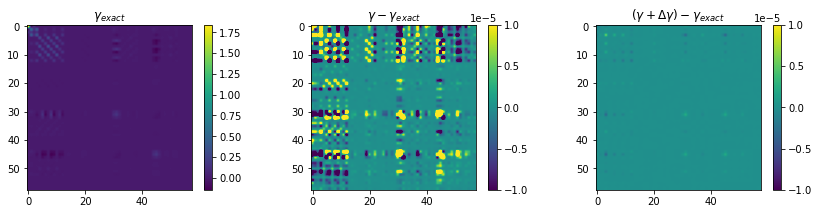

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].imshow(gamma_exact)
im1 = axs[1].imshow(gamma-gamma_exact, vmin=-1E-5, vmax=1E-5)
im2 = axs[2].imshow(gamma2-gamma_exact, vmin=-1E-5, vmax=1E-5)
axs[0].set_title(r'$\gamma_{exact}$')
axs[1].set_title(r'$\gamma-\gamma_{exact}$')
axs[2].set_title(r'$(\gamma+\Delta\gamma)-\gamma_{exact}$')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])
fig.tight_layout()

In [21]:
model.mmodels['d_dgamma']=LinearRegression()

In [22]:
model.fit(gammas, properties['gamma']-gammas, method = 'd_dgamma');

In [23]:
dgamma = model.predict(gamma, method='d_dgamma').reshape(shape)

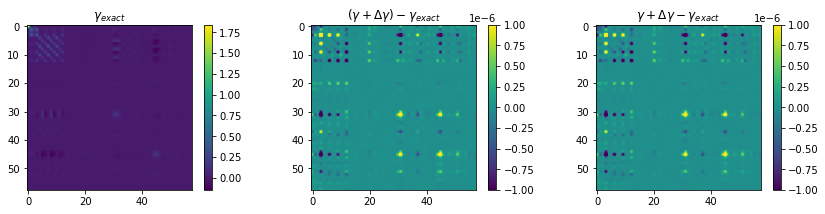

In [24]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].imshow(gamma_exact)
im1 = axs[1].imshow(gamma2-gamma_exact, vmin=-1E-6, vmax=1E-6)
im2 = axs[2].imshow(gamma+dgamma-gamma_exact, vmin=-1E-6, vmax=1E-6)
axs[0].set_title(r'$\gamma_{exact}$')
axs[1].set_title(r'$(\gamma+\Delta\gamma)-\gamma_{exact}$')
axs[2].set_title(r'$\gamma+\Delta\gamma-\gamma_{exact}$')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])
fig.tight_layout()

In [25]:
atoms_test=molecule('H2O')
atoms_test.positions[0,0] += 0.1
atoms_test.rotate(90, 'x')
atoms_test=atoms_test[[2,0,1]]
atoms_test

Atoms(symbols='HOH', pbc=False)

In [26]:
qmmol_exact= model.refqmmol.duplicate(atoms_test, refatoms=atoms_test)

In [27]:
gamma_test=model.predict(atoms_test)
model.predict(gamma_test, method='d_energy')-qmmol_exact.engine.etotal

1.9603016284008845e-05

In [28]:
forces_test = model.predict(gamma_test, method='d_forces')
forces_test.reshape((-1,3))

array([[-1.81896387e-14,  1.75294671e-06, -6.55589026e-03],
       [ 1.00240678e-14, -1.98038872e-03,  3.28000241e-03],
       [ 8.14289831e-15,  1.97863647e-03,  3.27590613e-03]])

In [29]:
qmmol_exact.engine.forces

array([[ 5.48608943e-04, -3.27857760e-03,  1.98972291e-03],
       [-1.09721789e-03,  6.55715520e-03, -2.14767427e-16],
       [ 5.48608943e-04, -3.27857760e-03, -1.98972291e-03]])

In [30]:
model.convert_back(forces_test, prop='forces')

array([[ 5.41798261e-04, -3.23079179e-03,  1.97863647e-03],
       [-1.08427098e-03,  6.46560543e-03,  1.75294671e-06],
       [ 5.42475740e-04, -3.23483166e-03, -1.98038872e-03]])

In [31]:
gamma_exact = qmmol_exact.engine.gamma

In [32]:
gamma2 = model.predict(gamma_test, method='d_gamma')

In [33]:
gamma = model.convert_back(gamma, method='gamma')
gamma2 = model.convert_back(gamma2, method='gamma')

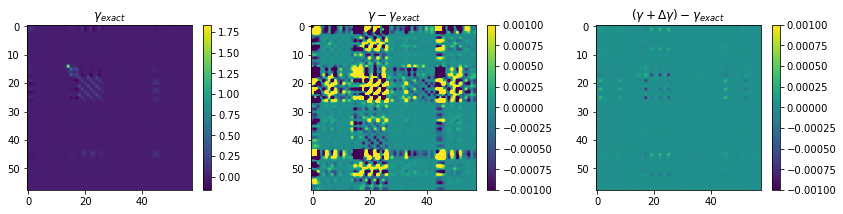

In [34]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
im0 = axs[0].imshow(gamma_exact)
im1 = axs[1].imshow(gamma-gamma_exact, vmin=-1E-3, vmax=1E-3)
im2 = axs[2].imshow(gamma2-gamma_exact, vmin=-1E-3, vmax=1E-3)
axs[0].set_title(r'$\gamma_{exact}$')
axs[1].set_title(r'$\gamma-\gamma_{exact}$')
axs[2].set_title(r'$(\gamma+\Delta\gamma)-\gamma_{exact}$')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])
fig.tight_layout()